In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 데이터셋 생성하기
dataset = pd.read_excel('dataset.xls')
dataset = dataset.astype({'기초금액':'int64', '추정가격':'int64', '투찰률':'float32', '낙찰금액':'int64'})
x_df = dataset[['기초금액', '추정가격', '투찰률']]
y_df = dataset['낙찰금액']

In [2]:
# 데이터 전처리
minmaxScaler = MinMaxScaler(feature_range=(0, 1))
standardScaler = StandardScaler()

x_df = minmaxScaler.fit_transform(x_df)
y_df = y_df.values
y_df = y_df.reshape(-1, 1)
y_df = standardScaler.fit_transform(y_df)

In [3]:
# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=2021)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=2021)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Epoch 1/4000
33/33 [==============================] - 13s 88ms/step - loss: 0.9110 - val_loss: 0.9675
Epoch 2/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.7153 - val_loss: 0.1067
Epoch 3/4000
33/33 [==============================] - 0s 7ms/step - loss: 0.0636 - val_loss: 0.0205
Epoch 4/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0142
Epoch 5/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.0233 - val_loss: 0.0094
Epoch 6/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0129
Epoch 7/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 8/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 9/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 10/4000
33/33 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.00

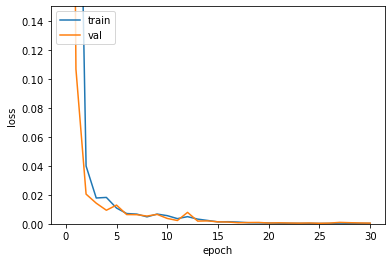

Train Score :  0.00018948304932564497
Validation Score :  0.0004634641809388995
Test Score :  0.0031115326564759016


In [4]:
early_stopping = EarlyStopping(patience=5)

# 2. 모델 구성하기
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(3, 1), return_sequences=True)))
model.add(Bidirectional(LSTM(70, activation="relu", return_sequences=True)))
model.add(Bidirectional(LSTM(30, activation="relu")))
#model.add(Dropout(0.2))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999))

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=4000, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score : ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validation Score : ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score : ', testScore)

In [5]:
prediction = model.predict(x_test)

In [6]:
test_set = standardScaler.inverse_transform(y_test)
pred_set = standardScaler.inverse_transform(prediction)

In [7]:
pred_set = pred_set.reshape(-1, 1)

In [8]:
test_set = pd.DataFrame(test_set)
pred_set = pd.DataFrame(pred_set)

test_set.columns = ['실제_낙찰가']
pred_set.columns = ['예측_낙찰가']

mg_data = pd.concat([test_set,pred_set],axis=1)

In [9]:
mg_data.head(10)

,실제_낙찰가,예측_낙찰가
0,2.704750e+08,2.664114e+08
1,6.331480e+08,6.322822e+08
2,4.496949e+08,4.441812e+08
3,3.235165e+08,3.191675e+08
4,1.272877e+09,1.262509e+09
5,3.501610e+07,3.539273e+07
6,1.739964e+09,1.729445e+09
7,2.156798e+08,2.093576e+08
8,1.325500e+08,1.267577e+08
9,7.815630e+08,7.744605e+08


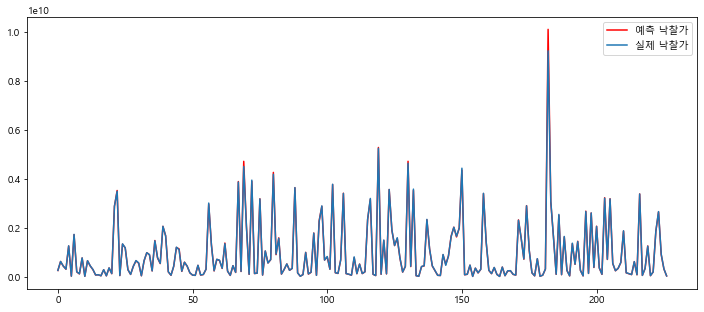

In [10]:
# 맑은 고딕 폰트 적용
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(12,5))
plt.plot(pred_set,'r',label="예측 낙찰가")
plt.plot(test_set,label="실제 낙찰가")
plt.legend()
plt.show()